Must needed setup before every assignment

In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 217.8MB 60kB/s 
     |████████████████████████████████| 204kB 46.4MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.5-py2.py3-none-any.whl size=218257927 sha256=c3d6e75bf13210d929aa2ad2022bd44d8ef8b7846e371e83a2d1ab76419ec82c
  Stored in directory: /root/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark
openjdk-8-jdk-headless is already the newest version (8u242-b08-0ubuntu3~18.04).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


Imports

In [0]:
import numpy as np
import time
import matplotlib.pyplot as pl

Variables

In [0]:
dataPath = ''

x = []

Open file

In [0]:
with open(dataPath + 'features.txt') as f:
    for line in f:
        x.append(list(map(int, line.split(','))))
x = np.array(x)

y = []
with open(dataPath + 'target.txt') as f:
    for line in f:
        y.append(int(line))
y = np.array(y)

Batch

In [18]:
t0 = time.time()
print('batch in progress', flush=True)
n, d = x.shape
w = np.zeros(d)
b = 0.
eta = .0000003
eps = .25
C = 100
y_xw_b = y * (x @ w + b)
fb = [w @ w / 2 + C * np.sum(np.maximum(0, 1 - y_xw_b))]

while True:
    mask = y_xw_b >= 1

    dLdw = -y[:, None] * x
    dLdb = -y
    dLdw[mask] = 0
    dLdb[mask] = 0
    dw = w + C * np.sum(dLdw, axis=0)
    db = C * np.sum(dLdb)

    w -= eta * dw
    b -= eta * db

    y_xw_b = y * (x @ w + b)
    fb.append(w @ w / 2 + C * np.sum(np.maximum(0, 1 - y_xw_b)))

    if 100 * abs(fb[-2] - fb[-1]) / fb[-2] < eps:
        break

t1 = time.time()

batch in progress


SGD

In [19]:
t2 = time.time()
print('sgd in progress', flush=True)
w = np.zeros(d)
b = 0.
eta = .0001
eps = .001
fs = [w @ w / 2 + C * np.sum(np.maximum(0, 1 - y * (x @ w + b)))]
prev_d = 0
ir = list(range(n))
np.random.shuffle(ir)
i = 0
while True:
    xi = x[ir[i]]
    yi = y[ir[i]]

    mask = yi * (xi @ w + b) >= 1
    dLdw = 0 if mask else -yi * xi
    dLdb = 0 if mask else -yi
    dw = w + C * dLdw
    db = C * dLdb
    w -= eta * dw
    b -= eta * db

    i += 1
    if i == n:
        i = 0
        np.random.shuffle(ir)

    fs.append(w @ w / 2 + C * np.sum(np.maximum(0, 1 - y * (x @ w + b))))
    curr_d = 100 * abs(fs[-2] - fs[-1]) / fs[-2]
    prev_d = .5 * prev_d + .5 * curr_d
    if prev_d < eps:
        break
      
t3 = time.time()

sgd in progress


Mini Batch

In [20]:
t4 = time.time()
print('minibatch in progress', flush=True)
w = np.zeros(d)
b = 0
prev_d = 0
batch_size = 20
eta = .00001
eps = .01
l = 0
perm = np.random.permutation(range(n))
x = x[perm]
y = y[perm]
fm = [w @ w / 2 + C * np.sum(np.maximum(0, 1 - y * (x @ w + b)))]
while True:
    xm = x[l:l + batch_size]
    ym = y[l:l + batch_size]

    mask = ym * (xm @ w + b) >= 1
    dLdw = -ym[:, None] * xm
    dLdb = -ym
    dLdw[mask] = 0
    dLdb[mask] = 0
    dw = w + C * np.sum(dLdw, axis=0)
    db = C * np.sum(dLdb)

    w -= eta * dw
    b -= eta * db

    l += batch_size
    if l >= n:
        l = 0
        perm = np.random.permutation(range(n))
        x = x[perm]
        y = y[perm]

    fm.append(w @ w / 2 + C * np.sum(np.maximum(0, 1 - y * (x @ w + b))))
    curr_d = 100 * abs(fm[-2] - fm[-1]) / fm[-2]
    prev_d = .5 * prev_d + .5 * curr_d
    if prev_d < eps:
        break
t5 = time.time()

minibatch in progress


Results and Output graphs

run name   time (s)    # iters    # epochs
batch          0.37         57          57
sgd            4.38       2188        0.34
minibatch      2.44       1159        3.61


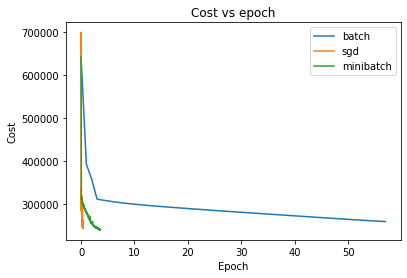

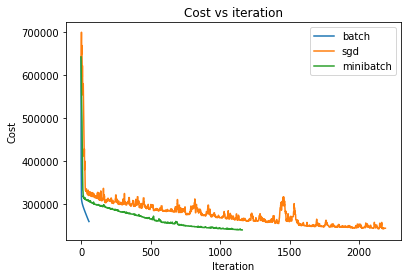

In [21]:
print('run name   time (s)    # iters    # epochs')
print('batch      %8.2f    %7d    %8d' % ((t1 - t0), (len(fb) - 1), (len(fb) - 1)))
print('sgd        %8.2f    %7d    %8.2f' % ((t3 - t2), (len(fs) - 1), ((len(fs) - 1) / n)))
print('minibatch  %8.2f    %7d    %8.2f' % ((t5 - t4), (len(fm) - 1), ((len(fm) - 1) / (np.ceil(n / batch_size)))))

pl.figure(0)
pl.plot(fb)
pl.plot(np.arange(len(fs)) / n, fs)
pl.plot(np.arange(len(fm)) / (np.ceil(n / batch_size)), fm)
pl.legend(['batch', 'sgd', 'minibatch'])
pl.title("Cost vs epoch")
pl.xlabel('Epoch')
pl.ylabel('Cost')


pl.figure(1)
pl.plot(fb)
pl.plot(fs)
pl.plot(fm)
pl.legend(['batch', 'sgd', 'minibatch'])
pl.title("Cost vs iteration")
pl.xlabel('Iteration')
pl.ylabel('Cost')
pl.savefig('plot.png', dpi=300, bbox_inches='tight')